In [16]:
import numpy as np
import pandas as pd
import tensorflow
import matplotlib.pyplot as plt
import matplotlib.image as img
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
import io
import os
import random
import shutil as sh

import warnings
warnings.filterwarnings('ignore')

In [17]:
df=pd.read_csv('../input/car-object-detection/data/train_solution_bounding_boxes (1).csv')
print(df)

max_values = df[['xmin', 'ymin', 'xmax', 'ymax']].max()
print(max_values)

               image        xmin        ymin        xmax        ymax
0     vid_4_1000.jpg  281.259045  187.035071  327.727931  223.225547
1    vid_4_10000.jpg   15.163531  187.035071  120.329957  236.430180
2    vid_4_10040.jpg  239.192475  176.764801  361.968162  236.430180
3    vid_4_10020.jpg  496.483358  172.363256  630.020260  231.539575
4    vid_4_10060.jpg   16.630970  186.546010  132.558611  238.386422
..               ...         ...         ...         ...         ...
554   vid_4_9860.jpg    0.000000  198.321729   49.235251  236.223284
555   vid_4_9880.jpg  329.876184  156.482351  536.664239  250.497895
556   vid_4_9900.jpg    0.000000  168.295823  141.797524  239.176652
557   vid_4_9960.jpg  487.428988  172.233646  616.917699  228.839864
558   vid_4_9980.jpg  221.558631  182.570434  348.585579  238.192196

[559 rows x 5 columns]
xmin    645.183792
ymin    208.064672
xmax    676.000000
ymax    308.322072
dtype: float64


In [18]:
image = img.imread('/kaggle/input/car-object-detection/data/training_images/vid_4_10020.jpg')
print(image.shape)

(380, 676, 3)


In [19]:
img_h, img_w, num_channels = (380, 676, 3)

df['image'] = df['image'].apply(lambda x: x.split('.')[0])

# preprocess the data for yolo object detection
df['x_center'] = (df['xmin'] + df['xmax'])/2
df['y_center'] = (df['ymin'] + df['ymax'])/2
df['w'] = df['xmax'] - df['xmin']
df['h'] = df['ymax'] - df['ymin']
df['classes'] = 0
df['status'] = 1

# scale the data
df['x_center'] = df['x_center']/img_w
df['w'] = df['w']/img_w
df['y_center'] = df['y_center']/img_h
df['h'] = df['h']/img_h

df.head()

,image,xmin,ymin,xmax,ymax,x_center,y_center,w,h,classes,status
0,vid_4_1000,281.259045,187.035071,327.727931,223.225547,0.450434,0.539817,0.068741,0.095238,0,1
1,vid_4_10000,15.163531,187.035071,120.329957,236.430180,0.100217,0.557191,0.155572,0.129987,0,1
2,vid_4_10040,239.192475,176.764801,361.968162,236.430180,0.444645,0.543678,0.181621,0.157014,0,1
3,vid_4_10020,496.483358,172.363256,630.020260,231.539575,0.833213,0.531451,0.197540,0.155727,0,1
4,vid_4_10060,16.630970,186.546010,132.558611,238.386422,0.110347,0.559122,0.171491,0.136422,0,1


In [20]:
df.image.nunique()

355

In [21]:
max_values = df[['xmin', 'ymin', 'xmax', 'ymax']].max()

print(max_values)

xmin    645.183792
ymin    208.064672
xmax    676.000000
ymax    308.322072
dtype: float64


In [22]:
df[['xmin', 'ymin', 'xmax', 'ymax']] =  np.divide(df[['xmin', 'ymin', 'xmax', 'ymax']], [676, 380, 676, 380])
print(df)

           image      xmin      ymin      xmax      ymax  x_center  y_center  \
0     vid_4_1000  0.416064  0.492198  0.484805  0.587436  0.450434  0.539817   
1    vid_4_10000  0.022431  0.492198  0.178003  0.622185  0.100217  0.557191   
2    vid_4_10040  0.353835  0.465171  0.535456  0.622185  0.444645  0.543678   
3    vid_4_10020  0.734443  0.453588  0.931983  0.609315  0.833213  0.531451   
4    vid_4_10060  0.024602  0.490911  0.196093  0.627333  0.110347  0.559122   
..           ...       ...       ...       ...       ...       ...       ...   
554   vid_4_9860  0.000000  0.521899  0.072833  0.621640  0.036417  0.571770   
555   vid_4_9880  0.487983  0.411796  0.793882  0.659205  0.640932  0.535500   
556   vid_4_9900  0.000000  0.442884  0.209760  0.629412  0.104880  0.536148   
557   vid_4_9960  0.721049  0.453246  0.912600  0.602210  0.816824  0.527728   
558   vid_4_9980  0.327749  0.480449  0.515659  0.626822  0.421704  0.553635   

            w         h  classes  statu

In [23]:
max_values = df[['xmin', 'ymin', 'xmax', 'ymax','w','h']].max()
print(max_values)

xmin    0.954414
ymin    0.547539
xmax    1.000000
ymax    0.811374
w       0.442113
h       0.361647
dtype: float64


In [24]:
if not os.path.exists(os.path.join('mydata', 'images')):
    os.makedirs(os.path.join('mydata', 'images'))

if not os.path.exists(os.path.join('mydata', 'labels')):
    os.makedirs(os.path.join('mydata', 'labels'))

for idx, data in df.groupby('image'):
    row = data[['classes', 'x_center', 'y_center', 'w', 'h']].astype(float).values
    row = row.astype(str)

    with open('mydata/labels/{}.txt'.format(idx), 'w+') as f:
        for i in range(len(row)):
            text = ' '.join(row[i])
            f.write(text)
            f.write('\n')

    sh.copy(
      '/kaggle/input/car-object-detection/data/training_images/{}.jpg'.format(idx),
      'mydata/images/{}.jpg'.format(idx)
    )

In [25]:
len(os.listdir(os.path.join('mydata', 'labels')))

355

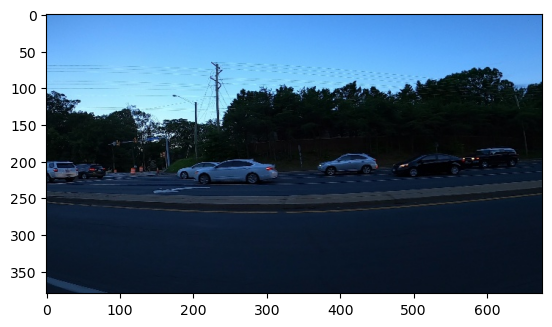

In [26]:
img=plt.imread('/kaggle/input/car-object-detection/data/training_images/vid_4_26460.jpg')
plt.imshow(img)

In [27]:
labels_path = '/kaggle/working/mydata/labels'
file_contents = []

# Loop through each file and read its contents
for file_name in os.listdir(labels_path):
    if file_name.endswith('.txt'):  # Only process TXT files
        file_path = os.path.join(labels_path, file_name)
        with open(file_path, 'r') as file:
            content = file.read()
            file_contents.append([file_name, content])

# Create a pandas DataFrame and display the data in tabular format
f = pd.DataFrame(file_contents, columns=['File Name', 'Contents'])
print(f)

#yaml file conversion txt->yaml(path+task)
#chat gpt/google
#official docum. of yolo v8 for input agrum. or parameters
#weights and biases
#official doc. read code
#train
#prediction: dowload new / updated weights and use it for predn.



           File Name                                           Contents
0    vid_4_11020.txt  0.0 0.056078147610946746 0.572635135131579 0.1...
1      vid_4_940.txt  0.0 0.329934450147929 0.5672360751315789 0.252...
2     vid_4_2160.txt  0.0 0.07091172214497042 0.5707046332894736 0.1...
3    vid_4_10020.txt  0.0 0.8332127352071006 0.5314510939473683 0.19...
4    vid_4_28840.txt  0.0 0.4153400868343195 0.5481821106578948 0.12...
..               ...                                                ...
350  vid_4_15040.txt  0.0 0.06331403762573964 0.5842181467105263 0.1...
351  vid_4_17360.txt  0.0 0.04450072358727811 0.564913127368421 0.08...
352  vid_4_16300.txt  0.0 0.8118668596153846 0.5179375803947368 0.10...
353   vid_4_6260.txt  0.0 0.1530390737795858 0.5655566280263158 0.11...
354   vid_4_1840.txt  0.0 0.292691751035503 0.5964446589473684 0.264...

[355 rows x 2 columns]


In [28]:
# install yolov8
!pip install ultralytics

In [29]:
from ultralytics import YOLO
import yaml

In [30]:
%%writefile dataset.yaml
# Path
path: /kaggle/working/mydata
train: images
val: images

# Classes
nc: 1
names: ['car']

Writing dataset.yaml


In [31]:
# disable wandb
import wandb
wandb.init(mode="disabled")

In [32]:
# Load a model
model = YOLO('yolov8n.yaml')  # build a new model from YAML
model = YOLO('yolov8n.pt')  # load a pretrained model (recommended for training)
model = YOLO('yolov8n.yaml').load('yolov8n.pt')  # build from YAML and transfer weights

# Train the model
model.train(data='dataset.yaml', epochs=10, imgsz=640)


                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

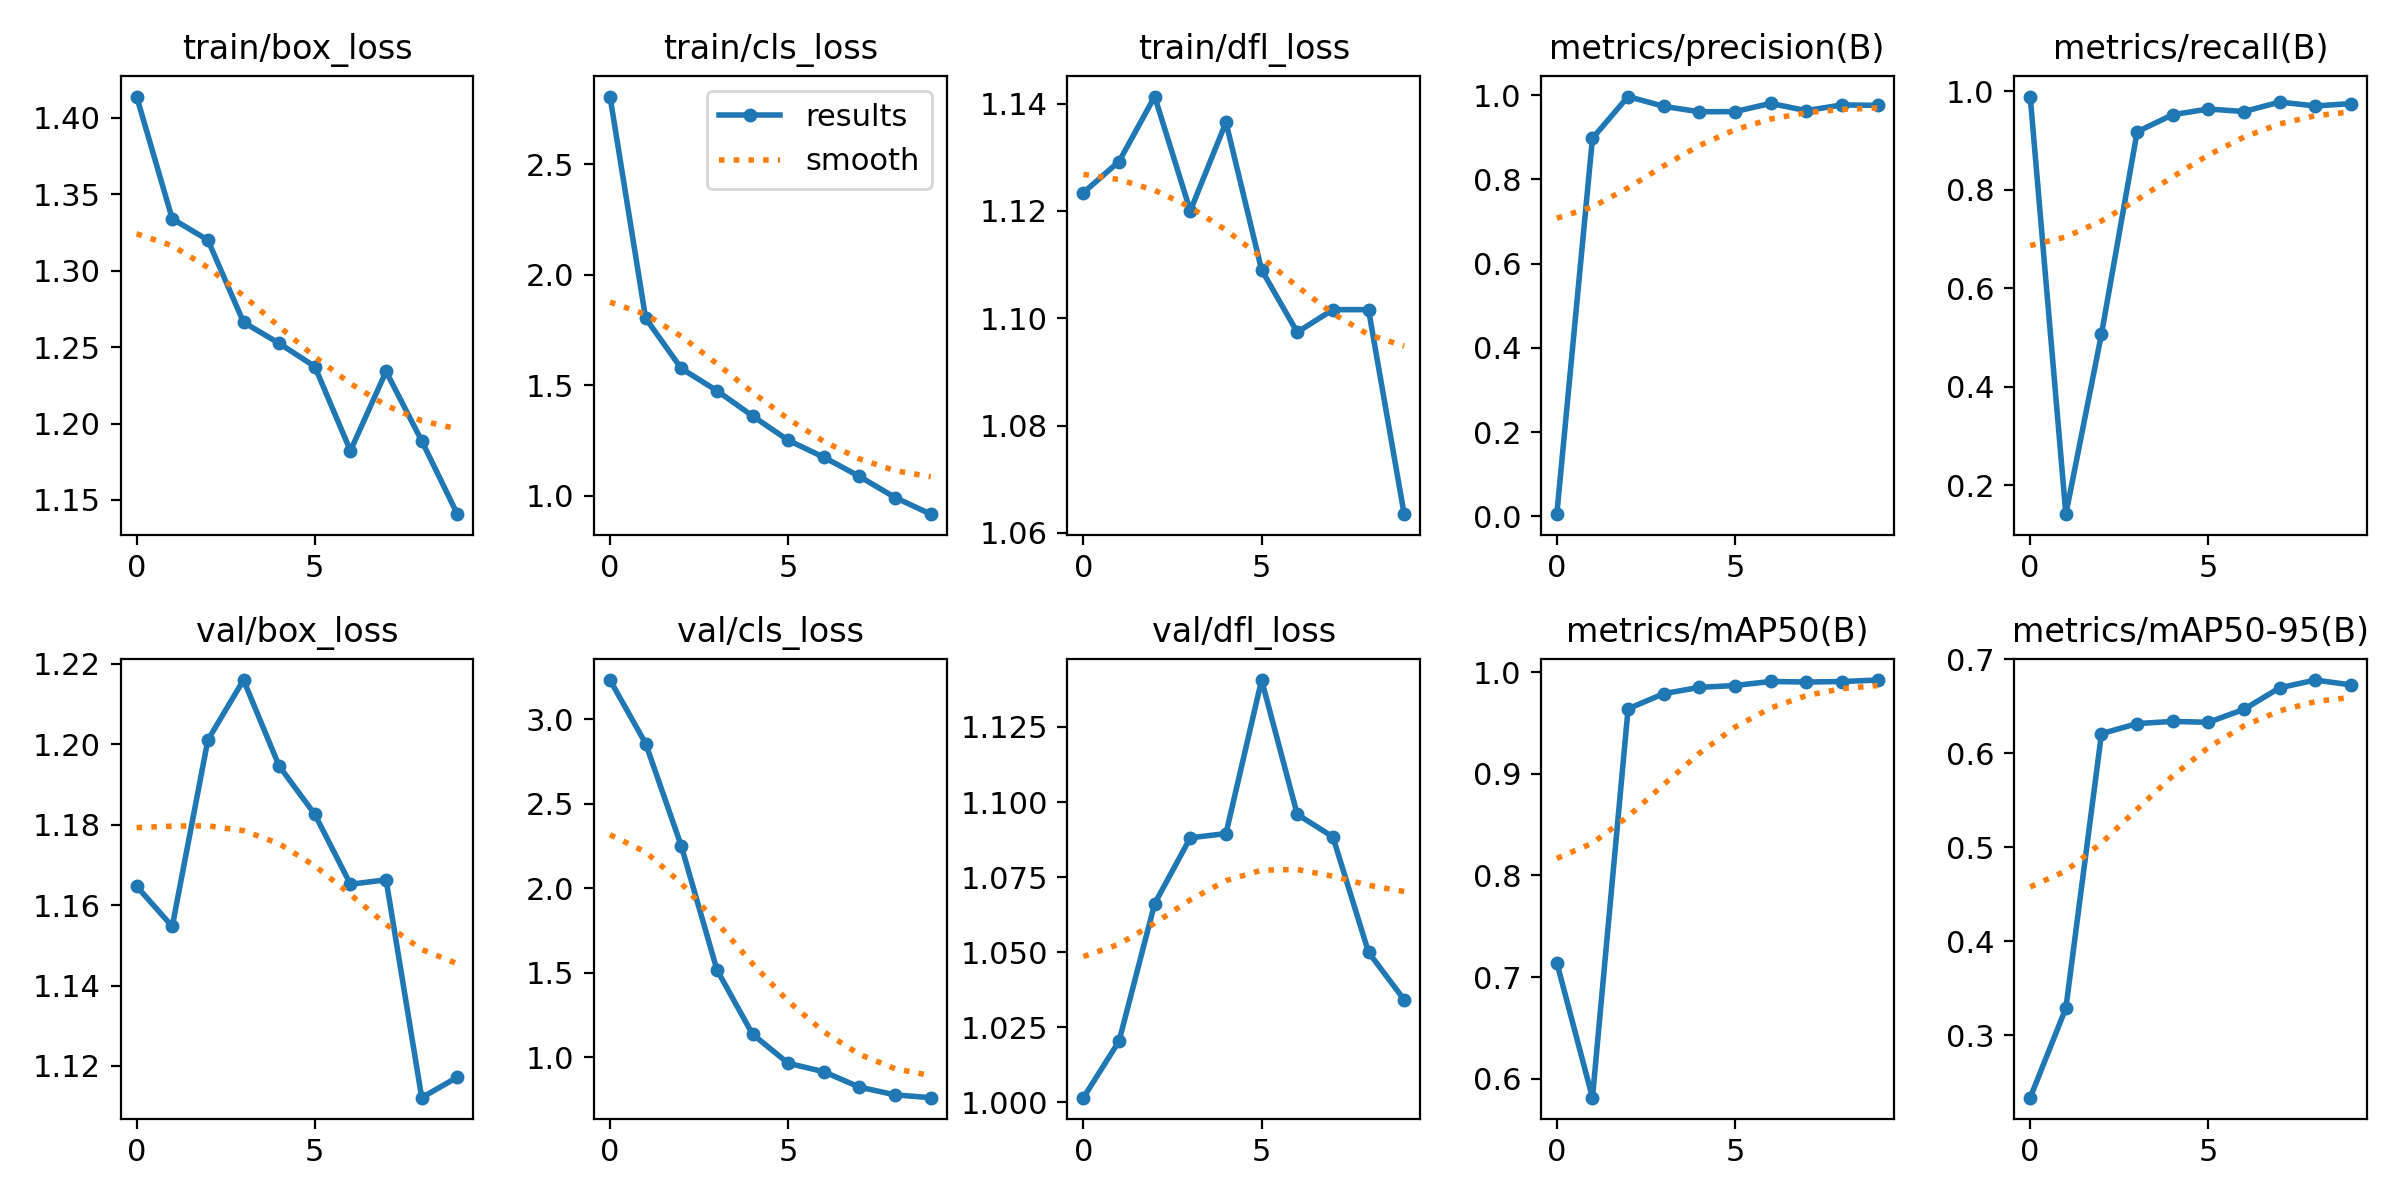

In [33]:
from IPython.display import Image

Image("/kaggle/working/runs/detect/train/results.png")


In [41]:
model = YOLO('./runs/detect/train/weights/last.pt')
ret = model("https://motorlease.com/wp-content/uploads/2018/06/AdobeStock_88405879-1.jpeg",save=True, conf=0.2, iou=0.5)


100%|██████████| 334k/334k [00:00<00:00, 960kB/s] 
image 1/1 /kaggle/working/AdobeStock_88405879-1.jpeg: 448x640 2 cars, 98.7ms
Speed: 3.5ms preprocess, 98.7ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)
Results saved to runs/detect/predict4


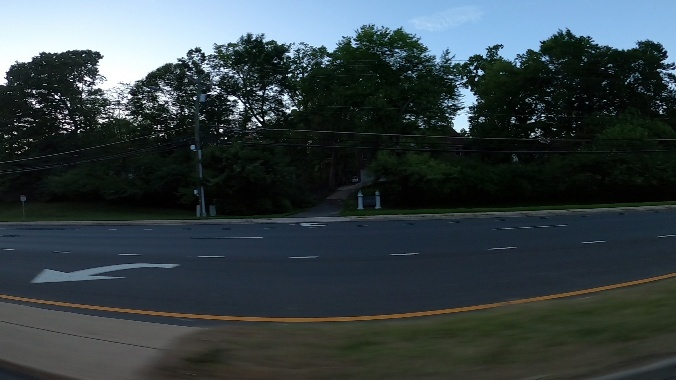

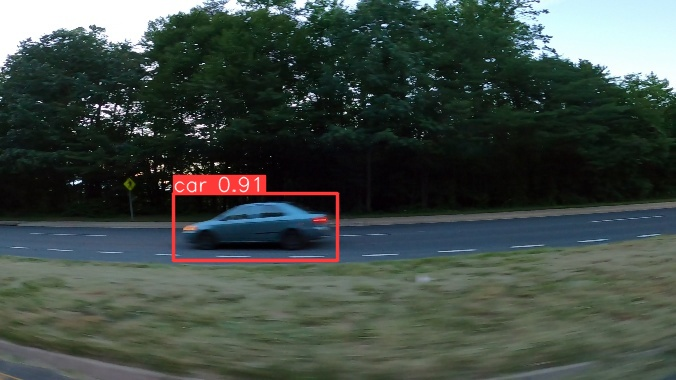

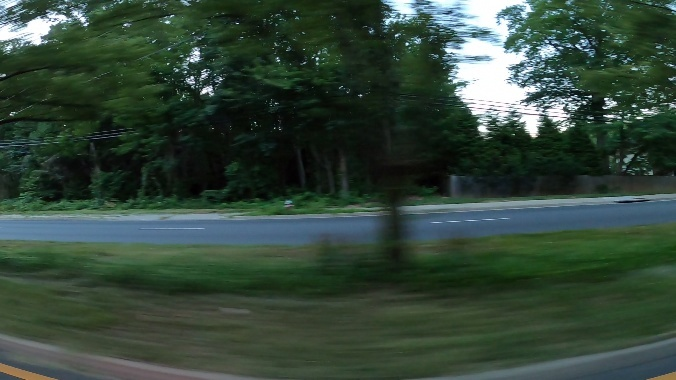

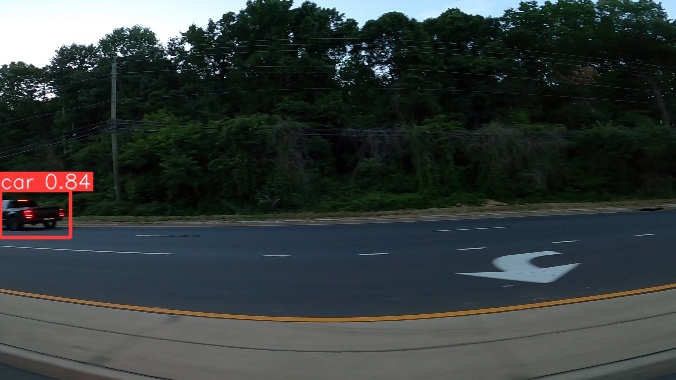

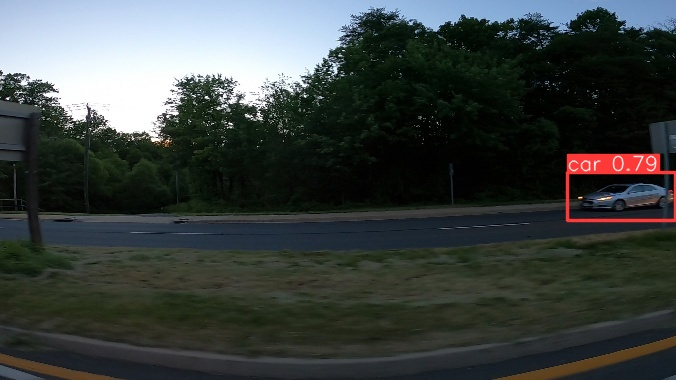

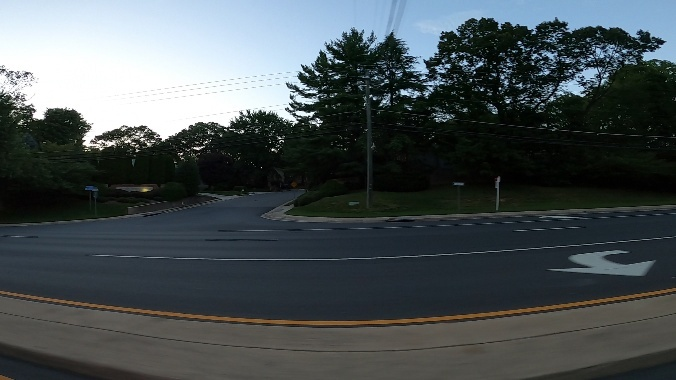

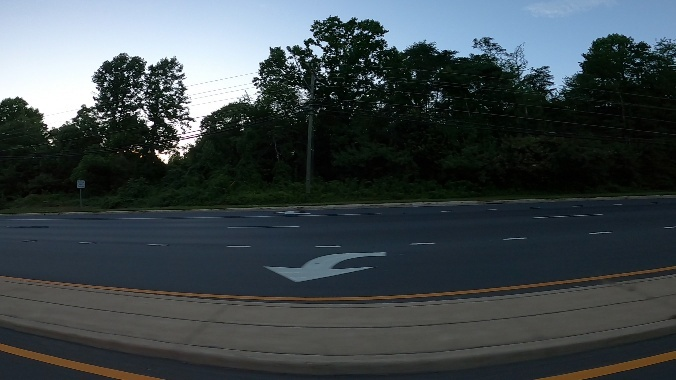

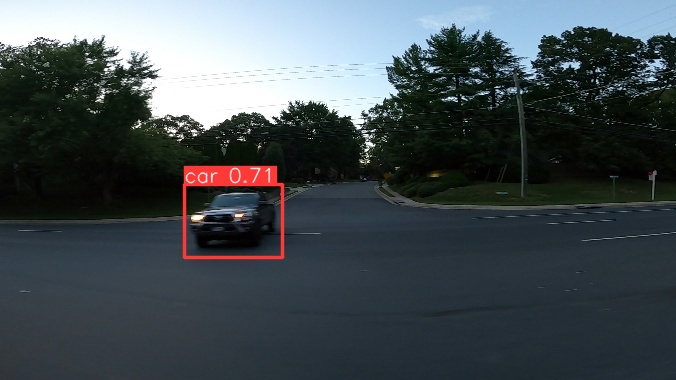

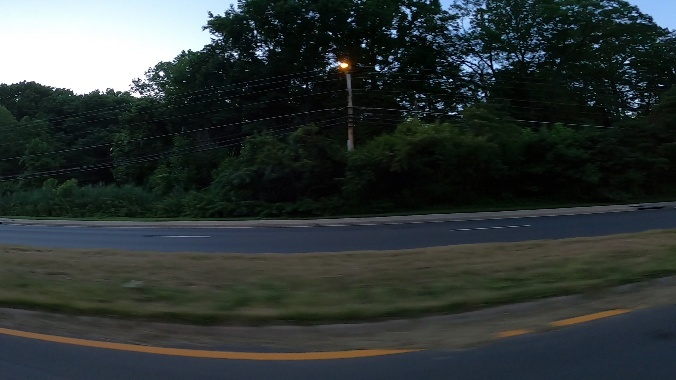

In [ ]:
import glob
# display result
files = glob.glob("./runs/detect/predict2/*")
for i in range(0, 30, 3):
    img = Image(files[i])
    display(img)